<a href="https://colab.research.google.com/github/fppfurtado/mvp-pos-ciencia-de-dados/blob/main/Projeto_MVP_Preditor_de_Pre%C3%A7os_de_T%C3%ADtulos_P%C3%BAblicos_Federais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definição do Problema

## Objetivo
O presente projeto tem como objetivo a construção de um modelo de regressão linear para auxiliar o investidor a decidir o melhor momento de marcar a mercado seu título público, prevendo as taxas de juros ofertadas por títulos públicos federais - e, consequentemente, seus preços unitários - a partir dos valores da taxa de câmbio dolar/real (Ptax), do índice IBOVESPA e do CDS Brasil 5 anos.

## Títulos Públicos Federais
Títulos Públicos Federais são títulos de dívida emitidos pelo Governo Federal para financiar suas atvidades captando recursos de particulares em troca de pagamento de juros sobre um capital aplicado. Na prática, são **ativos de renda fixa** que possuem preço, taxa e vencimento definidos, e que podem ser adquiridos por investidores interessados.

Esses ativos possuem liquidez diária, podendo o investidor solicitar o resgate a qualquer tempo (durante o horário de funcionamento do mercado de títulos publicos), porém nesse caso o valor utilizado para o cálculo da rentabilidade será o **valor de mercado do título** no dia da solicitação de resgate, a chamada **Marcação a Mercado**, que pode fazer com que o investidor tenha ou lucro acima do esperado ou prejuízo no resgate antecipado.

O preço dos títulos públicos variam em função das respectivas taxas ofertadas. E as taxas variam diariamente, basicamente, em função da percepção de risco do mercado em relação à economia do país. Por isso, após alguma notícia negativa no cenário econômico, é comum observar fenômenos como "queda na bolsa", "alta no dolar" e "alta nos juros" pagos pelos títulos públicos federais.

## IBOVESPA
O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.

Reavaliado a cada quatro meses, o índice é resultado de uma carteira teórica de ativos. É composto pelas ações e units de companhias listadas na B3 que atendem aos critérios descritos na sua metodologia, correspondendo a cerca de 80% do número de negócios e do volume financeiro do nosso mercado de capitais.

Fonte: https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

## PTax
Ptax é uma taxa de câmbio calculada durante o dia pelo Banco Central do Brasil. Consiste na média das taxas de compra e de venda informadas pelas instituições financeiras durante 4 janelas do dia. É a taxa de referencia para o valor do dólar de D2 (em dois dias úteis). Normalmente, os contratos de derivativos de câmbio são liquidados com base na PTAX divulgada para o dia útil anterior.

Fonte: https://pt.wikipedia.org/wiki/Ptax

## CDS Brasil
CDS (credit default swap) é a troca de risco de crédito. O CDS é um contrato derivativo que funciona como um seguro para quem empresta dinheiro. Por levar em sua precificação o risco de inadimplência do tomador do empréstimo, o CDS é muito usado como termômetro para o risco de um país.

Fonte: https://inteligenciafinanceira.com.br/glossario/credit-default-swap-cds-risco-pais/

# 2. Coleta e Análise de Dados

## Importação de Pacotes e Módulos

In [69]:
# Importando pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

## Configurações prévias

In [70]:
# Suprimindo warnings
warnings.filterwarnings('ignore')

## Carregamento e Preparação dos Dados

Serão carregados os datasets dos dados históricos das quatro variáveis econômicas que serão tratadas posteriormente pelo modelo de regressão linear: 

+ taxas e preços de título públicos federais
+ taxa de câmbio PTax
+ índice IBOVESPA
+ CDS Brasil 5 anos.

In [71]:
# Carregando o histórico de preços de preços e taxas de títulos públicos
historico_titulos = pd.read_csv('https://github.com/fppfurtado/mvp-pos-ciencia-de-dados/raw/main/DADOS/historico_titulos.csv', decimal = ',')
# Carregando o histórico do índice IBOVESPA
historico_ibov = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_ibov.csv', decimal = ',')
# Carregando o histórico da taxa de câmbio PTax
historico_ptax = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_ptax.csv', decimal = ',')
# Carregando o histórico do CDS Brasil 5 Anos
historico_cds5y = pd.read_csv('https://raw.githubusercontent.com/fppfurtado/mvp-pos-ciencia-de-dados/main/DADOS/historico_csd5y.csv', decimal = ',')

Cada dataset possui um conjunto de atributos próprio, muitos dos quais não serão relevantes em nosso projeto. Por esse motivo, selecionaremos apenas os atributos relevantes e faremos a junção em um dataset final de trabalho utilizando como chave os atributos temporais (datas).

In [72]:
# exibindo os nomes das colunas (atributos) dos datasets
print('atributos titulos:', historico_titulos.columns, '\n')
print('atributos ibov:', historico_ibov.columns, '\n')
print('atributos ptax:', historico_ptax.columns, '\n')
print('atributos cds5y:', historico_cds5y.columns, '\n')

atributos titulos: Index(['Tipo Titulo', 'Data Vencimento', 'Data Base', 'Taxa Compra Manha',
       'Taxa Venda Manha', 'PU Compra Manha', 'PU Venda Manha',
       'PU Base Manha'],
      dtype='object') 

atributos ibov: Index(['direction_color', 'rowDate', 'rowDateRaw', 'rowDateTimestamp',
       'last_close', 'last_open', 'last_max', 'last_min', 'volume',
       'volumeRaw', 'change_precent', 'last_closeRaw', 'last_openRaw',
       'last_maxRaw', 'last_minRaw', 'change_precentRaw'],
      dtype='object') 

atributos ptax: Index(['data', 'valor'], dtype='object') 

atributos cds5y: Index(['direction_color', 'rowDate', 'rowDateRaw', 'rowDateTimestamp',
       'last_close', 'last_open', 'last_max', 'last_min', 'volume',
       'volumeRaw', 'change_precent', 'last_closeRaw', 'last_openRaw',
       'last_maxRaw', 'last_minRaw', 'change_precentRaw'],
      dtype='object') 



Para o histórico de títulos públicos, selecionaremos os atributos: Tipo Titulo, Data Vencimento, Data Base, Taxa Venda Manha.

In [73]:
# reduzindo o dataset historico_titulos por meio da seleção de atributos relevantes
historico_titulos = historico_titulos[['Tipo Titulo', 'Data Vencimento', 'Data Base', 'Taxa Venda Manha']]

Para o histórico do Ibovespa, selecionaremos os atributos: rowDate, volumeRaw, change_precent.

In [74]:
# reduzindo o dataset historico_ibov por meio da seleção de atributos relevantes
historico_ibov = historico_ibov[['rowDate', 'volumeRaw', 'change_precent']]

Para o histórico da taxa de câmbio, como são apenas dois atributos, manteremos a mesma configuração.

Para o histórico do CDS Brasil 5 Anos, selecionaremos os atributos: rowDate, volumeRaw e change_precent.

In [75]:
# reduzindo o dataset historico_csd5y por meio da seleção de atributos relevantes
historico_cds5y = historico_cds5y[['rowDate', 'change_precent']]

Vamos garantir que os atributos temporais que sequenciam as séries históricas estejam armazenados como data, a fim de utilizá-los como chaves na junção dos datasets.

In [76]:
# ajustando tipos dos atributos temporais
historico_titulos['Data Base'] = historico_titulos['Data Base'].astype('datetime64')
historico_ibov['rowDate'] = historico_ibov['rowDate'].astype('datetime64')
historico_ptax['data'] = historico_ptax['data'].astype('datetime64')
historico_cds5y['rowDate'] = historico_cds5y['rowDate'].astype('datetime64')

Vamos agora juntar os datasets com base nos atributos temporais.

In [77]:
# mesclando o historico de titulos com o historico ibov com base em atributo de data
df_merge = pd.merge(historico_titulos, historico_ibov, left_on='Data Base', right_on='rowDate', suffixes=('_titulos', '_ibov'))
# mesclando o dataset df_merge com o historico ptax com base em atributo de data
df_merge = pd.merge(df_merge, historico_ptax, left_on='Data Base', right_on='data', suffixes=('_titulos', '_ptax'))
# mesclando o dataset df_merge com o historico CDS 5 anos com base em atributo de data
df_merge = pd.merge(df_merge, historico_cds5y, left_on='Data Base', right_on='rowDate', suffixes=('_ibov', '_cds'))
# exibindo as primeiras linhas para visualização do resultado
df_merge.head(5)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,rowDate_ibov,volumeRaw,change_precent_ibov,data,valor,rowDate_cds,change_precent_cds
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,2020-12-17,7701390,0.46,2020-12-17,5.0606,2020-12-17,-1.26


Por fim, vamos eliminar os atributos temporais duplicados e renomear alguns atributos.

In [78]:
# eliminando atributos irrelevantes
df_merge = df_merge.drop(columns=['rowDate_ibov', 'data', 'rowDate_cds'])
# renomeando atributos
df_merge = df_merge.rename(columns={
    'volumeRaw': 'Volume IBOV',
    'change_precent_ibov': 'Variação IBOV',
    'valor': 'Valor Dolar',
    'change_precent_cds': 'Variação CDS'
})
# exibindo as primeiras linhas
df_merge.head(5)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,7701390,0.46,5.0606,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,7701390,0.46,5.0606,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,7701390,0.46,5.0606,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,7701390,0.46,5.0606,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,7701390,0.46,5.0606,-1.26


## Análise Exploratória

Para a exploração dos dados dos datasets, seguiremos o seguinte roteiro para cada dataset:

1. Descrição e Classificação dos Dados Brutos
2. Estrutura do Dataset
3. Estatísticas Descritivas
4. Visualizações Unimodais
5. Visualizações Multimodais

### Estrutura do Dataset

Vamos iniciar a análise observando informações gerais sobre a estrutura do dataset de trabalho.

In [79]:
# exibindo informações gerais sobre o dataset
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28694 entries, 0 to 28693
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Tipo Titulo       28694 non-null  object        
 1   Data Vencimento   28694 non-null  object        
 2   Data Base         28694 non-null  datetime64[ns]
 3   Taxa Venda Manha  28694 non-null  object        
 4   Volume IBOV       28694 non-null  int64         
 5   Variação IBOV     28694 non-null  object        
 6   Valor Dolar       28694 non-null  object        
 7   Variação CDS      28694 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.0+ MB


O resumo acima nos informa as dimensões do dataset (28694 linhas, 08 colunas), os nomes de seus atributos, bem como seus respectivos tipos de dados e a quantidade de registros não-nulos (*missings*) para cada atributo.

Com a exceção dos atributos "Data Base" (tipo "datetime64") e "Volume IBOV" (tipo "int64"), todos os demais estão armazenados como "object" no dataset, que é uma tipagem genérica para texto, o que pode dificultar certas operações com os dados. Tal problema pode ser contornado com a conversão dos atributos para os tipos adequados.

É possível notar a falta de *missings* (valores nulos) nos atributos do dataset. Isso é explicado pela fato de o dataset não possuir dados oriundos de inputs de usuário (ex.: formulários), mas apenas dados computados automaticamente pelos sistemas de negociação dos respectivos ativos.

### Descrição e Classificação dos Dados Brutos

Agora vamos observar os dados brutos exibindo algumas linhas do dataset.

In [80]:
# exibindo linhas de fronteiras (início e fim) do dataset
df_merge

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
0,Tesouro Prefixado com Juros Semestrais,2029-01-01,2020-12-17,6.97,7701390,0.46,5.0606,-1.26
1,Tesouro IPCA+,2026-08-15,2020-12-17,2.54,7701390,0.46,5.0606,-1.26
2,Tesouro IPCA+,2024-08-15,2020-12-17,1.79,7701390,0.46,5.0606,-1.26
3,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2020-12-17,-0.3,7701390,0.46,5.0606,-1.26
4,Tesouro Prefixado,2023-01-01,2020-12-17,4.61,7701390,0.46,5.0606,-1.26
...,...,...,...,...,...,...,...,...
28689,Tesouro IPCA+ com Juros Semestrais,2020-08-15,2018-01-03,3.87,3239424,0.13,3.2614,-2.21
28690,Tesouro IGPM+ com Juros Semestrais,2021-04-01,2018-01-03,4.2,3239424,0.13,3.2614,-2.21
28691,Tesouro Prefixado,2023-01-01,2018-01-03,9.8,3239424,0.13,3.2614,-2.21
28692,Tesouro Prefixado com Juros Semestrais,2021-01-01,2018-01-03,8.71,3239424,0.13,3.2614,-2.21


Observando os dados brutos, podemos classificar e descrever seus atributos:

+ <u>VARIÁVEL QUALITATIVA NOMINAL</u>
  + **Tipo Titulo**: o título público negociado.
+ <u>VARIÁVEL TEMPORAL</u>
  + **Data Vencimento**: a data de vencimento do título público.
  + **Data Base**: a data de referência da operação/negociação.
+ <u>VARIÁVEL QUANTITATIVA CONTÍNUA</u>
  + **Taxa Venda Manha**: a parte fixa da taxa de juros paga pelo título público.
  + **Volume IBOV**: o volume financeiro negociado pelas ações que compõem o índice Ibovespa.
  + **Variação IBOV**: o percentual de variação do índice Ibovespa em relação ao dia de negociação anterior.
  + **Valor Dolar**: o valor do dólar Ptax.
  + **Variação CDS**: o percentual de variação dos pontos-base do CDS Brasil 5 anos.

Abaixo podemos verificar quais tipos de títulos foram ofertados ao longo do período e a quantidade de ofertas associada a cada título.

In [81]:
# exibindo a quantidade registros por título
df_merge['Tipo Titulo'].value_counts()

Tesouro IPCA+ com Juros Semestrais        8100
Tesouro Prefixado com Juros Semestrais    5813
Tesouro Prefixado                         5337
Tesouro IPCA+                             4195
Tesouro Selic                             3456
Tesouro IGPM+ com Juros Semestrais        1793
Name: Tipo Titulo, dtype: int64

O título "Tesouro IGPM+" possui quantidade de registros significativamente inferior aos demais por ter sido ofertado pelo Tesouro Nacional até o ano de 2006.

In [82]:
# exibindo linhas de fronteiras (início e fim) do dataset ordenadas pelo atributo 'Data Base'
df_merge.sort_values('Data Base', ascending = False)

,Tipo Titulo,Data Vencimento,Data Base,Taxa Venda Manha,Volume IBOV,Variação IBOV,Valor Dolar,Variação CDS
4094,Tesouro IPCA+ com Juros Semestrais,2055-05-15,2022-12-29,6.23,13389109,-0.46,5.2171,-0.06
4101,Tesouro Prefixado,2024-07-01,2022-12-29,13.05,13389109,-0.46,5.2171,-0.06
4086,Tesouro Prefixado com Juros Semestrais,2023-01-01,2022-12-29,14.2,13389109,-0.46,5.2171,-0.06
4087,Tesouro Prefixado,2025-01-01,2022-12-29,12.71,13389109,-0.46,5.2171,-0.06
4088,Tesouro Prefixado com Juros Semestrais,2029-01-01,2022-12-29,12.82,13389109,-0.46,5.2171,-0.06
...,...,...,...,...,...,...,...,...
22817,Tesouro IPCA+,2035-05-15,2018-01-02,5.56,2969444,1.95,3.1724,-3.76
22816,Tesouro Selic,2021-03-01,2018-01-02,0.04,2969444,1.95,3.1724,-3.76
22815,Tesouro IPCA+ com Juros Semestrais,2035-05-15,2018-01-02,5.43,2969444,1.95,3.1724,-3.76
22814,Tesouro Prefixado,2019-01-01,2018-01-02,6.89,2969444,1.95,3.1724,-3.76


Verificamos pela tabela acima a coerência e abrangência temporal dos dados do atributo "Data Base", compreendendo o período de 02/01/2018 até 29/12/2022.

### Estatísticas Descritivas

Nesta seção vamos exibir as principais estatísticas descritivas dos atributos quantitativos da dataset. Mas para isso precisaremos primeiramente realizar algumas conversões de tipo, uma vez que vários atributos quantitativos estão armazenados como *object* (texto) no dataset.

In [83]:
# convertendo atributos do tipo "objetc" para os tipos adequados
df_merge = df_merge.astype({
    'Data Vencimento': 'datetime64',
    'Taxa Venda Manha': 'float64',
    'Variação IBOV': 'float64',
    'Valor Dolar': 'float64',
    'Variação CDS': 'float64'
})

Também será necessário criarmos uma nova coluna para classificar os títulos de acordo com o prazo até o vencimento, pois as taxas de juros apresentam comportamentos diferentes quanto maiores os prazos.

In [84]:
#(df_merge['Data Vencimento'] - df_merge['Data Base'])/np.timedelta64(1, 'Y')
def classificarPrazo(qtdAnos):
  if(qtdAnos <= 1):
    return '1. curto'
  elif(qtdAnos <= 5):
    return '2. medio'
  else:
    return '3. longo'

df_merge['Tipo Prazo'] = (df_merge['Data Vencimento'] - df_merge['Data Base'])/np.timedelta64(1, 'Y')
df_merge['Tipo Prazo'] = df_merge['Tipo Prazo'].apply(classificarPrazo)

Vamos agora observar um resumo estatístico da variável "Taxa Venda Manha" para cada tipo de título ofertado.

In [85]:
# exibindo as estatísticas descritivas do atributo "Taxa Venda Manha" agrupadas por título.
df_merge.groupby(['Tipo Titulo', 'Tipo Prazo']).describe()['Taxa Venda Manha'].applymap('{:,.2f}'.format)

count   mean   std  \
Tipo Titulo                            Tipo Prazo                          
Tesouro IGPM+ com Juros Semestrais     1. curto      213.00  -0.83  1.74   
                                       2. medio      491.00   3.01  1.32   
                                       3. longo    1,089.00   4.51  1.06   
Tesouro IPCA+                          1. curto      221.00   2.25  1.22   
                                       2. medio    1,113.00   4.24  1.72   
                                       3. longo    2,861.00   4.61  1.00   
Tesouro IPCA+ com Juros Semestrais     1. curto      218.00   1.42  2.24   
                                       2. medio    1,391.00   4.10  1.61   
                                       3. longo    6,491.00   4.73  1.00   
Tesouro Prefixado                      1. curto    1,089.00   6.95  3.66   
                                       2. medio    3,444.00   8.43  2.78   
                                       3. longo      804.00   9.38  2.37   
Tesouro Prefixado com Juros Semestrais 1. curto      437.00   8.11  5.40   
                                       2. medio    2,178.00   8.45  2.68   
                                       3. longo    3,198.00   9.53  2.13   
Tesouro Selic                          1. curto      400.00   0.04  0.02   
                                       2. medio    2,562.00   0.09  0.07   
                                       3. longo      494.00   0.16  0.13   

                                                     min    25%    50%    75%  \
Tipo Titulo                            Tipo Prazo                               
Tesouro IGPM+ com Juros Semestrais     1. curto    -3.30  -2.14  -0.85   0.25   
                                       2. medio     0.50   2.01   3.21   4.06   
                                       3. longo     2.65   3.45   4.47   5.58   
Tesouro IPCA+                          1. curto    -1.42   2.17   2.56   3.08   
                                       2. medio     1.32   2.51   4.59   5.69   
                                       3. longo     2.16   3.80   4.55   5.49   
Tesouro IPCA+ com Juros Semestrais     1. curto    -3.00  -0.06   1.29   2.28   
                                       2. medio     1.24   2.78   3.94   5.59   
                                       3. longo     2.02   4.01   4.64   5.69   
Tesouro Prefixado                      1. curto     1.95   4.66   6.48   7.25   
                                       2. medio     2.75   6.34   8.23  10.73   
                                       3. longo     5.96   7.06   9.05  11.79   
Tesouro Prefixado com Juros Semestrais 1. curto     1.89   2.19  11.93  13.78   
                                       2. medio     3.76   6.21   8.21  10.94   
                                       3. longo     5.93   7.44   9.32  11.55   
Tesouro Selic                          1. curto     0.01   0.02   0.03   0.05   
                                       2. medio     0.01   0.03   0.05   0.15   
                                       3. longo     0.03   0.03   0.06   0.30   

                                                     max  
Tipo Titulo                            Tipo Prazo         
Tesouro IGPM+ com Juros Semestrais     1. curto     5.08  
                                       2. medio     5.27  
                                       3. longo     6.54  
Tesouro IPCA+                          1. curto     3.73  
                                       2. medio     7.38  
                                       3. longo     6.59  
Tesouro IPCA+ com Juros Semestrais     1. curto     7.13  
                                       2. medio     7.43  
                                       3. longo     6.57  
Tesouro Prefixado                      1. curto    14.20  
                                       2. medio    14.31  
                                       3. longo    13.80  
Tesouro Prefixado com Juros Semestrais 1. curto    14.20  
                           

Nota-se que o título com maior desvio padrão são os título do tipo "Prefixado", o que possivelmente indica uma maior volatilidade (risco) dessa categoria de ativo. Esse tipo de característica é considerada importante nos casos de marcação a mercado, pois possibilita maior lucro (ou prejuízo).

In [86]:
# calculando a amplitude por tipo de título e de prazo
max_titulo_prazo = pd.DataFrame(df_merge.groupby(['Tipo Titulo', 'Tipo Prazo']).describe()['Taxa Venda Manha']['max']).pivot_table(index='Tipo Titulo', columns='Tipo Prazo', values='max')
min_titulo_prazo = pd.DataFrame(df_merge.groupby(['Tipo Titulo', 'Tipo Prazo']).describe()['Taxa Venda Manha']['min']).pivot_table(index='Tipo Titulo', columns='Tipo Prazo', values='min')
max_titulo_prazo - min_titulo_prazo

Tipo Prazo,1. curto,2. medio,3. longo
Tipo Titulo,,,
Tesouro IGPM+ com Juros Semestrais,8.38,4.77,3.89
Tesouro IPCA+,5.15,6.06,4.43
Tesouro IPCA+ com Juros Semestrais,10.13,6.19,4.55
Tesouro Prefixado,12.25,11.56,7.84
Tesouro Prefixado com Juros Semestrais,12.31,10.33,7.89
Tesouro Selic,0.15,0.37,0.33


Acima podemos observar as amplitudes das taxas por tipo de prazo para cada título. Os títulos do tipo "Prefixado" apresentam o maior valor de amplitude, o que combinado com sua característica de maior desvio padrão, confirma sua característica de categoria mais volátil do grupo.

In [87]:
# exibindo as estatísticas descritivas dos demais atributos quantitativos
df_merge.describe()[['Volume IBOV', 'Valor Dolar', 'Variação IBOV', 'Variação CDS']].applymap('{:,.2f}'.format)

,Volume IBOV,Valor Dolar,Variação IBOV,Variação CDS
count,"28,694.00","28,694.00","28,694.00","28,694.00"
mean,"8,617,119.96",4.72,0.04,0.08
std,"4,080,040.44",0.76,1.77,3.57
min,"424,315.00",3.14,-14.78,-25.88
25%,"4,933,512.00",3.94,-0.79,-1.39
50%,"8,584,901.00",5.09,0.08,-0.01
75%,"11,476,269.00",5.34,0.98,1.27
max,"26,029,316.00",5.94,13.91,30.61


Acima o resumo estatísticos dos demais atributos quantitativos do dataset. Chama a atenção os valores do atributo "Variação CDS", onde podemos notar como o desvio padrão é relativamente alto em relação à média e como o terceiro quartil está distante do valor máximo, indicando que esse provavelmente é um indicador bastante volátil.

### Visualizações Unimodais

In [88]:
# exibindo o histograma do atributo 'Taxa Venda Manha'
#df_merge.groupby('Tipo Titulo')['Taxa Venda Manha'].hist(figsize = (15,10), edgecolor='black', bins=8)
#df_taxas = df_merge.pivot_table(index=['Data Base', 'Tipo Titulo'], columns=['Tipo Prazo'], values='Taxa Venda Manha')
#df_taxas.hist(figsize=(15,10), edgecolor='black', bins=8)

df_tipo_titulos = {}

for titulo in df_merge['Tipo Titulo'].unique():
  df_tipo_titulos[titulo] = df_merge[df_merge['Tipo Titulo'] == titulo].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')

# df_prefixados = df_merge[df_merge['Tipo Titulo'] == 'Tesouro Prefixado'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')
# df_prefixados_sem = df_merge[df_merge['Tipo Titulo'] == 'Tesouro Prefixado com Juros Semestrais'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')
# df_ipca = df_merge[df_merge['Tipo Titulo'] == 'Tesouro IPCA+'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')
# df_ipca_sem = df_merge[df_merge['Tipo Titulo'] == 'Tesouro IPCA+ com Juros Semestrais'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')
# df_selic = df_merge[df_merge['Tipo Titulo'] == 'Tesouro Selic'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')
# df_igpm_sem = df_merge[df_merge['Tipo Titulo'] == 'Tesouro IGPM+ com Juros Semestrais'].pivot_table(index=['Data Base'], columns='Tipo Prazo', values='Taxa Venda Manha')

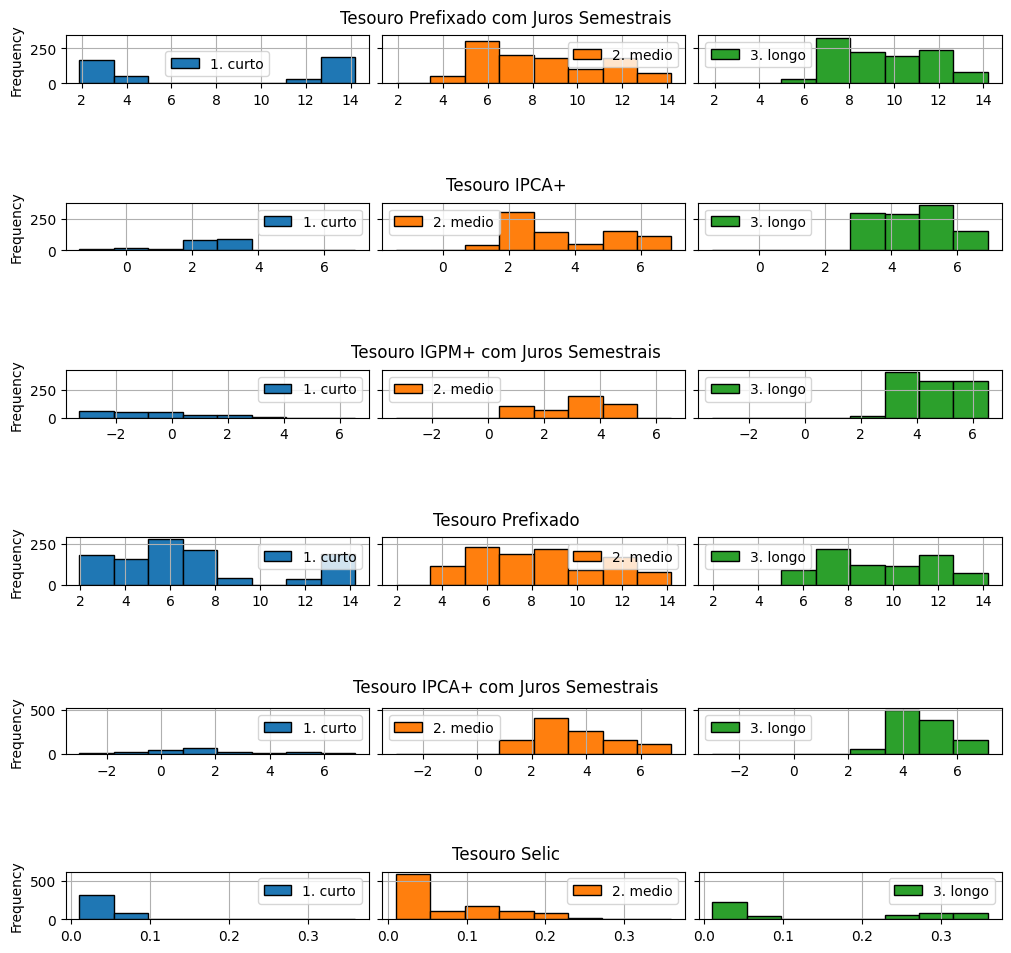

In [89]:
n_titulos = len(df_merge['Tipo Titulo'].unique())

cont = 0
fig = plt.figure(constrained_layout = True, figsize=(10,10))

ax =[]

subfigs = fig.subfigures(n_titulos, 1)

for titulo, dados in df_tipo_titulos.items():
  ax.append(subfigs[cont].subplots(1,1))
  dados.plot(kind='hist', subplots=True, figsize=(12,4), layout=(2,3), edgecolor='black',sharex=True, sharey=True, bins=8, grid=True, ax = ax[cont])
  subfigs[cont].suptitle(titulo)
  cont += 1

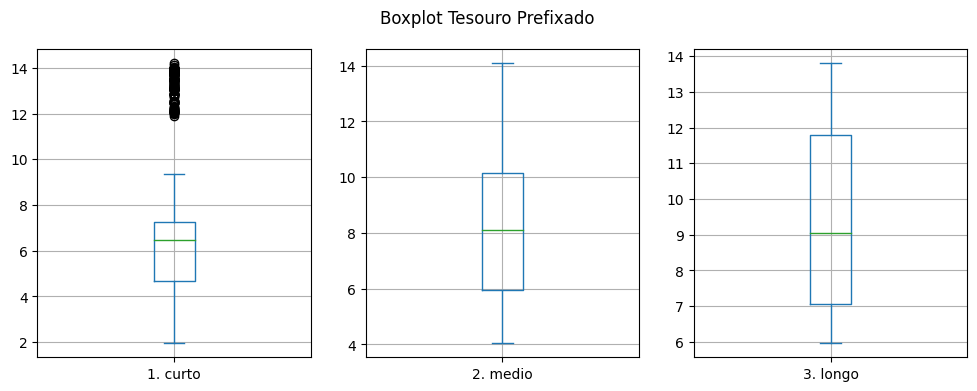

In [90]:
# exibindo os boxplots dos atributos quantitativos
df_prefixados.plot(kind = 'box', subplots = True, layout = (1,3), sharex = False, sharey = False, figsize = (12,4), grid=True)
plt.suptitle('Boxplot Tesouro Prefixado')
plt.show()

Ambos os gráficos indicam que as taxas de maior frequência, e consequentemente de maior probabilidade de ocorrência de acordo com o histórico, são aquelas cujos valores estão entre 0 e 10.

Nos boxplots acima, chama a atenção os gráficos de variação (IBOV e CDS) com característica "espremida", exibindo uma grande quantidade de outliers (dados discrepantes da maioria) nos conjuntos de dados. Como já comentado anteriormente, tais dados não podem ser considerados inputs errados pela própria natureza dos datasets. 

Nesse caso, não é prudente eliminar tais registros, uma vez que eles provavelmente capturam uma parte do comportamento real dos atributos. O que poderá ser feito posteriormente é testar um tratamento à parte desses outliers junto aos modelos estatísticos para avaliar qual a melhor opção.

### Visualizações Multimodais

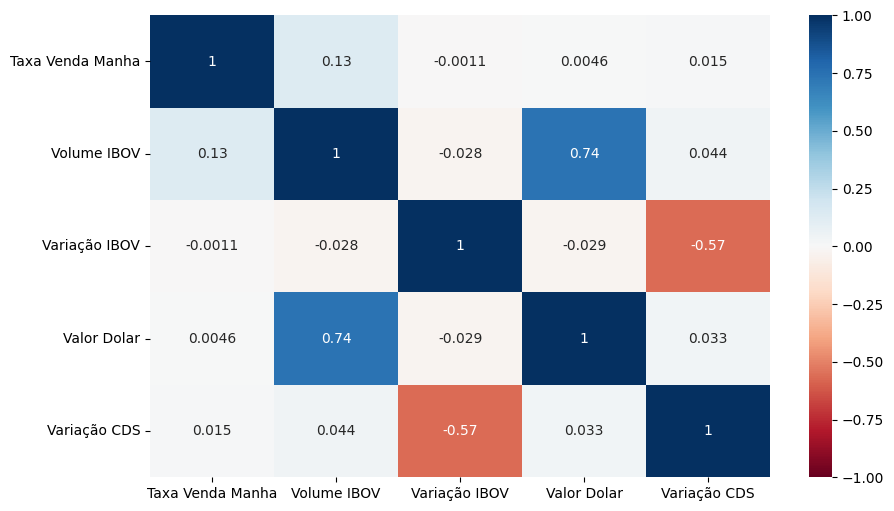

In [91]:
# matriz de correlação dos atributos
plt.figure(figsize = (10,6))
sns.heatmap(df_merge.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

No gráfico acima, é possível observar uma forte correlação positiva entre os atributos "Volume IBOV" e "Valor Dolar", bem como uma forte correlação negativa entre os atributos "Variação IBOV" e "Variação CDS".